# Map algebra

- Reclassify (Basic calculations)
- Focal function
- Local function
- Zonal function (zonal statistics)

**To be updated**

Conducting calculations between bands or raster is another common GIS task. 


In the following, we will cover some of the basic DEM analysis approaches using `xarray` and `xarray-spatial` libraries in order to gain knowledge of topography of an area. The goal in the following section is to calculate and use different surface features to find a suitable place for building a new summer house. To do this, we will use information for example about elevation, slope and aspect of the terrain. so think of a scenario where all of these can be utilized. The criteria for finding a suitable place for a summer cottage will be based on following preferences:

- The higher the elevation, the better
- Some slope is good but not too steep
- The ridge should be pointing South (who wouldn't like more sun on their patio..)

## Focal functions

A focal function operates on a cell and its neighboring cells within a defined window (e.g., 3x3 or 5x5). The output value for each cell is derived by applying a mathematical or statistical operation to the values within that neighborhood.


In [3]:
import xarray as xr
import xrspatial
import matplotlib.pyplot as plt

fp = "data/Tuupovaara_DEM.nc"
data = xr.open_dataset(fp, decode_coords="all")
data

<xarray.Dataset> Size: 1MB
Dimensions:      (x: 400, y: 400)
Coordinates:
  * x            (x) float64 3kB 3.69e+06 3.69e+06 3.69e+06 ... 3.7e+06 3.7e+06
  * y            (y) float64 3kB 6.95e+06 6.95e+06 ... 6.94e+06 6.94e+06
    spatial_ref  int64 8B ...
Data variables:
    elevation    (y, x) float64 1MB ...
Attributes:
    AREA_OR_POINT:  Area

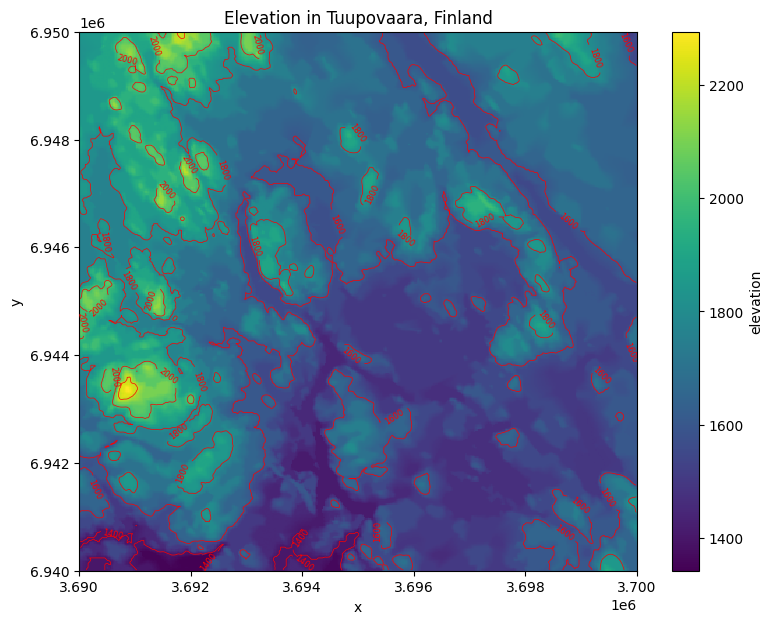

In [4]:
# Plot the elevation values and contours
fig, ax = plt.subplots(figsize=(9,7))
data["elevation"].plot(ax=ax)
cs = data["elevation"].plot.contour(ax=ax, colors="red", linewidths=0.5)

# Label contours
ax.clabel(cs, cs.levels, inline=True, fontsize=6);
plt.title("Elevation in Tuupovaara, Finland");

### Slope

In [5]:
# Calculate slope 
data["slope"] = xrspatial.slope(data["elevation"])

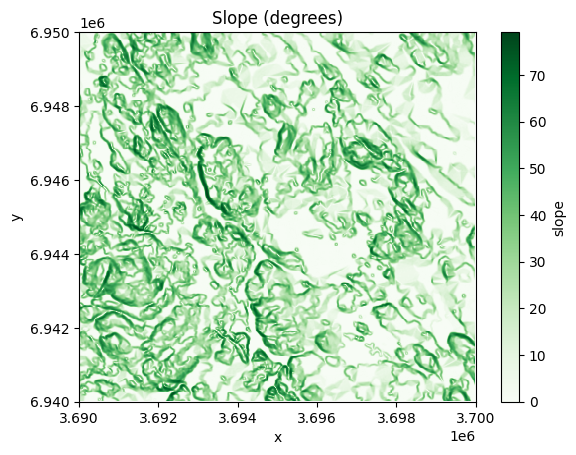

In [9]:
data["slope"].plot(cmap="Greens")
plt.title("Slope (degrees)");

### Aspect

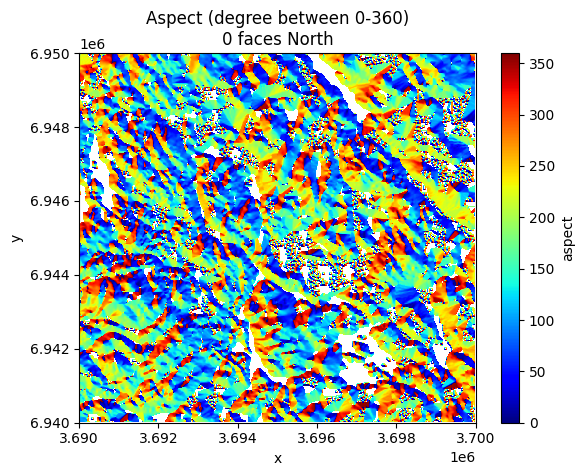

In [10]:
# Calculate aspect
data["aspect"] = xrspatial.aspect(data["elevation"])
# Filter values that are below 0 (areas without aspect defined)
data["aspect"] = data["aspect"].where(data["aspect"] >=0)
data["aspect"].plot(cmap="jet")
plt.title("Aspect (degree between 0-360)\n0 faces North");

### Curvature

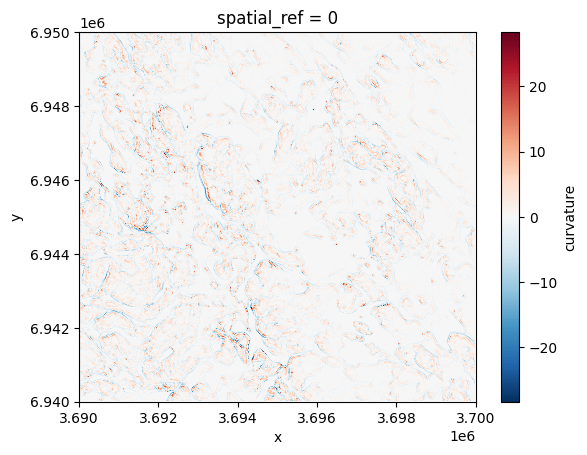

In [11]:
data["curvature"] = xrspatial.curvature(data["elevation"])
data["curvature"].plot()

### Hillshade

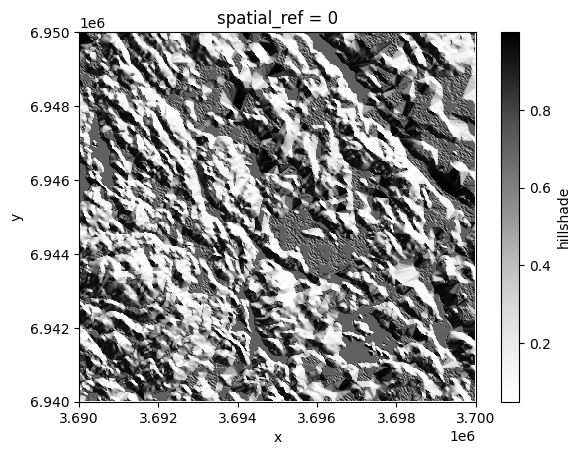

In [13]:
data["hillshade"] = xrspatial.hillshade(data["elevation"])
data["hillshade"].plot(cmap="Greys")

In [48]:
# Calculate relative height
data["relative_height"] = data["elevation"] - data["elevation"].min().item()

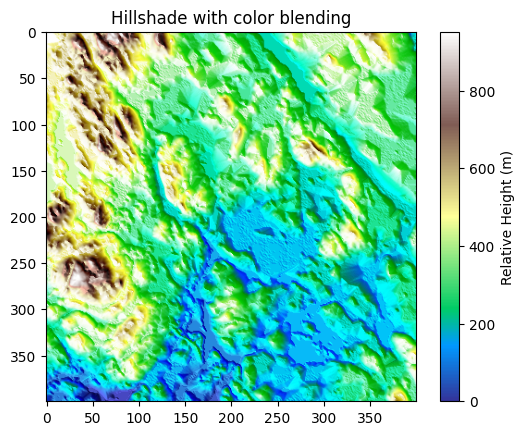

In [53]:
from matplotlib.colors import LightSource, Normalize
import matplotlib.colorbar as cbar
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots()

# Specify the colormap to use
colormap = plt.cm.terrain

# Specify the light source
ls = LightSource(azdeg=225, altdeg=25)

# Convert DataArray into numpy array
array = data["relative_height"].to_numpy()

# Normalize elevation for color mapping
norm = Normalize(vmin=np.min(array), vmax=np.max(array))

# Create hillshade based on elevation
hillshade = ls.shade(array, cmap=colormap, vert_exag=1, blend_mode="overlay")
ax.imshow(hillshade)
ax.set_title("Hillshade with color blending");

# Create a ScalarMappable for colorbar
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # Needed for colorbar creation

# Add colorbar
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", label="Relative Height (m)")

## Reclassify


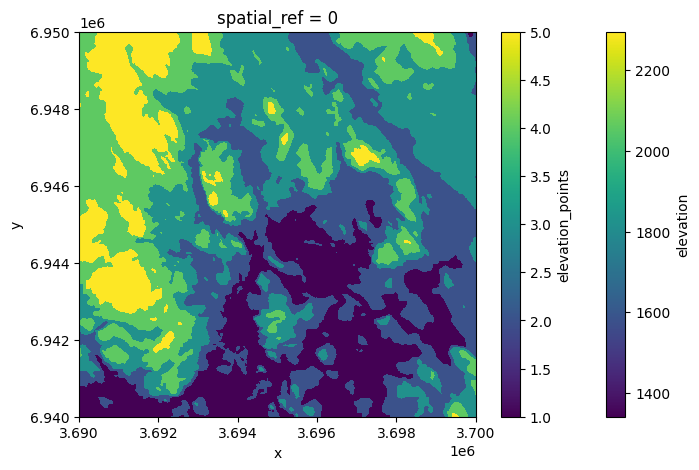

In [57]:
# Take 20 % sample to reduce the time it takes to classify
percentage = 0.2

# The sample size
n = int(round(int(data["elevation"].count()) * percentage, 0))

# Reclassify elevation into 5 classes and add number 1 to the result to make the scale from 1-5
data["elevation_points"] = xrspatial.classify.natural_breaks(data["elevation"], k=5, num_sample=n) + 1

# Plot the result
fig, ax = plt.subplots(figsize=(8,5))
data["elevation"].plot(ax=ax);
data["elevation_points"].plot(ax=ax);

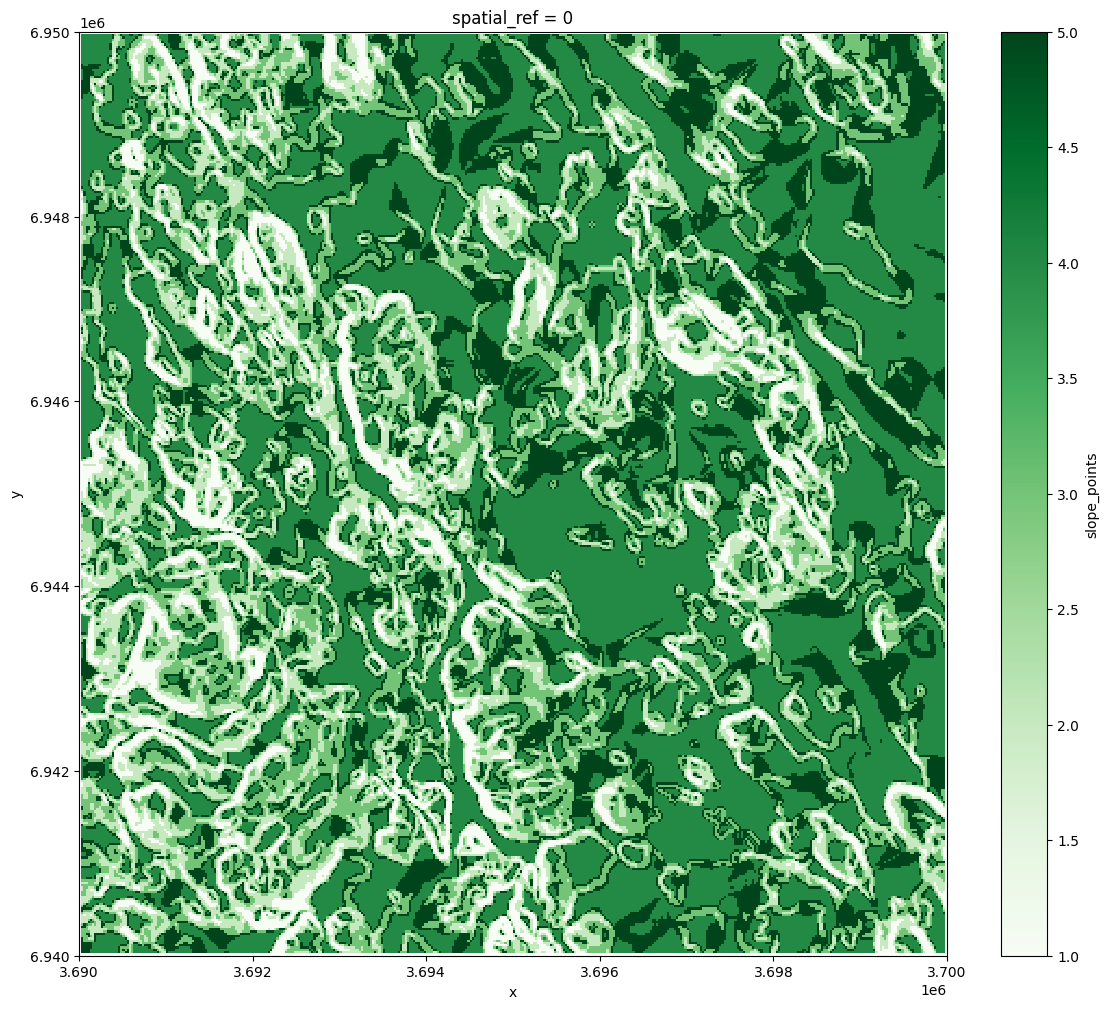

In [59]:
bins = [1,2,3,4,5]
new_values = [4,5,3,2,1]

data["slope_nb"] = xrspatial.classify.natural_breaks(data["slope"], k=5, num_sample=n) + 1
data["slope_points"] = xrspatial.classify.reclassify(data["slope_nb"], bins=bins, new_values=new_values)

# Plot
fig, ax = plt.subplots(figsize=(14,12))
data["slope_points"].plot(ax=ax, cmap="Greens");

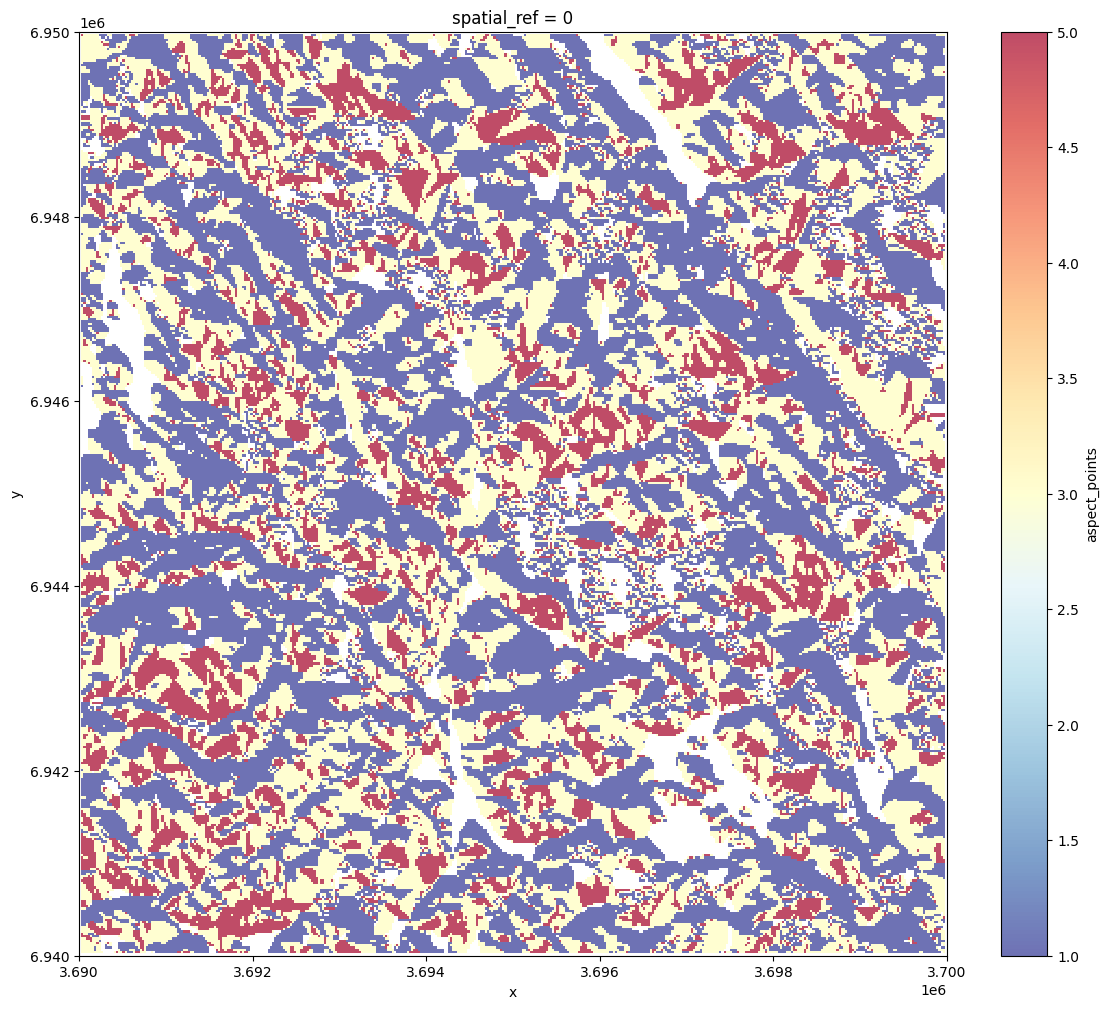

In [60]:
bins = [90, 150, 210, 270, 360]
new_values = [1, 3, 5, 3, 1]

# Classify
data["aspect_points"] = xrspatial.classify.reclassify(data["aspect"], bins=bins, new_values=new_values) 

# Make a plot
fig, ax = plt.subplots(figsize=(14,12))
data["aspect_points"].plot(ax=ax, cmap="RdYlBu_r", alpha=0.7);

## Local functions

To be added. 

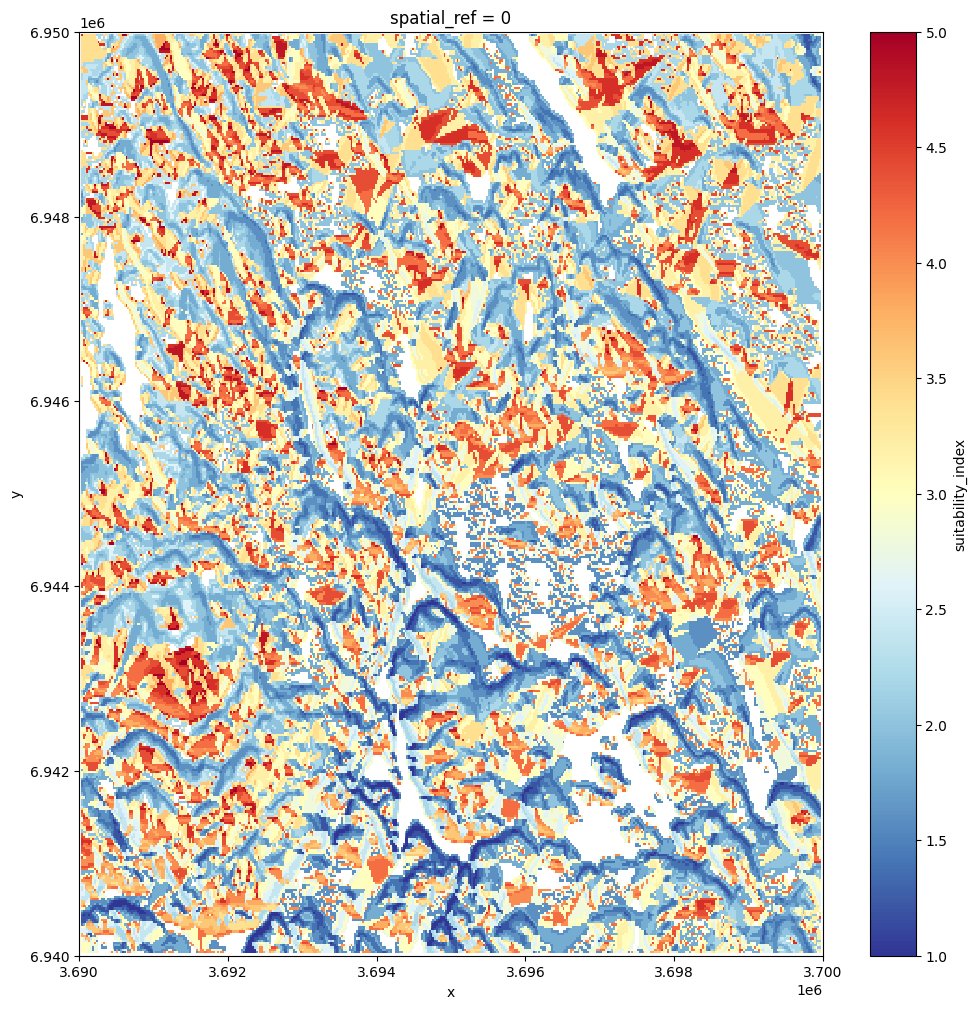

In [61]:
# Calculate the suitability index by weighting the "points" given for different layers
data["suitability_index"] = data["elevation_points"]*0.2 + data["aspect_points"]*0.6 + data["slope_points"]*0.2

# Plot the suitability index
data["suitability_index"].plot(cmap="RdYlBu_r", figsize=(12,12));

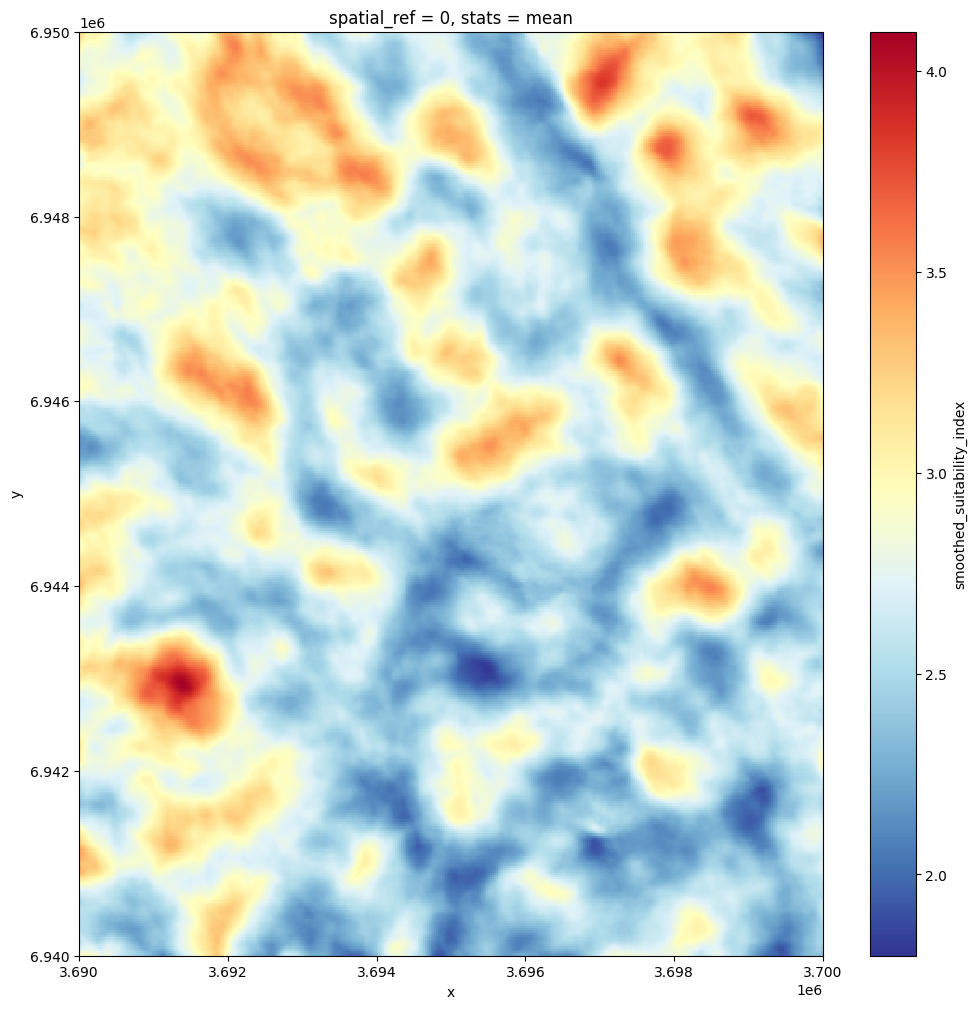

In [62]:
from xrspatial.convolution import circle_kernel

# Kernel size
k = 15

# Generate a kernel (basically produces a boolean matrix full with numbers 1 and 0)
kernel = circle_kernel(1, 1, k)

# Smoothen the surface
data["smoothed_suitability_index"] = xrspatial.focal.focal_stats(data["suitability_index"], kernel, stats_funcs=["mean"])

# Plot the result
data["smoothed_suitability_index"].plot(cmap="RdYlBu_r", figsize=(12,12));

## Global functions

In map algebra, global functions are operations where the output value of each cell depends on the entire dataset or a large spatial extent, not just local neighbors. These functions are used to analyze patterns, relationships, and spatial influences across the whole raster. They are essential for modeling cumulative effects, spatial dependencies, and large-scale patterns in fields like hydrology, transportation, and environmental science.

- Statistical summaries: global mean, max, min etc.
- Viewshed analysis
- Cost distance and least-cost path
- Proximity (distance, allocation, direction)

## Zonal functions

To be added. 

## Incremental functions

To be added. 